# Collaborative filtering deep

In [1]:
from functools import reduce
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dot, Concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

pd.set_option('display.max_columns', None)

def save(obj, path):
    with open(path, 'bw') as file:
        pickle.dump(obj, file)

def load(path):
    with open(path, 'br') as file:
        return pickle.load(file)

def missing(df):
    return df[df.isna().any(axis='columns')]

def chain_layers(*layers):
    return reduce(lambda output, layer: layer(output), layers)

def plot_loss(history):
    n_epoch = len(history['loss'])
    xs = np.arange(1, n_epoch + 1)
    fig, ax = plt.subplots()
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.plot(xs, history['loss'], label='Train')
    ax.plot(xs, history['val_loss'], label='Validation')
    ax.legend()
    return fig

def plot_acc(history):
    n_epoch = len(history['accuracy'])
    xs = np.arange(1, n_epoch + 1)
    fig, [loss, acc] = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    loss.set_ylabel('Loss')
    loss.plot(xs, history['loss'], label='Train')
    loss.plot(xs, history['val_loss'], label='Validation')
    acc.set_xlabel('Epoch')
    acc.set_ylabel('Accuracy')
    acc.plot(xs, history['accuracy'])
    acc.plot(xs, history['val_accuracy'])
    fig.legend()
    return fig

def print_rg_report(y, y_pred):
    print(f'MSE = {mean_squared_error(y, y_pred)}\nMAE = {mean_absolute_error(y, y_pred)}')

def plot_preds(y, y_pred):
    n_classes = len(np.unique(y))
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    ax.set_xlim(0, n_classes + 1)
    ax.set_xticks(np.arange(1, n_classes + 1))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.scatter(y, y_pred, s=64, alpha=1 / 256)
    return fig

def print_cl_report(y, y_pred):
    print(classification_report(y, y_pred))

def plot_rocc(y, Y_prob):
    n_classes = Y_prob.shape[1]
    first_class = (n_classes == 2 and 1) or 0
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.plot([0, 1], [0, 1], "--")
    for cl in range(first_class, n_classes):
        fpr, tpr, _ths = roc_curve(y, Y_prob[:, cl], pos_label=cl)
        ax.plot(fpr, tpr, label=f'{cl}, AUC = {auc(fpr, tpr):.2f}')
    ax.legend()
    return fig

def plot_confmat(y, y_pred):
    n_classes = len(np.unique(y))
    confmat = confusion_matrix(y, y_pred)
    max_v = confmat.max()
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    xys = np.arange(n_classes)
    ax.set_xticks(xys)
    ax.set_yticks(xys)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.imshow(confmat, vmin=max_v * -1, vmax=max_v, cmap='coolwarm')
    for actual in range(n_classes):
        for predicted in range(n_classes):
            ax.text(predicted, actual, confmat[actual, predicted], ha='center', va='center')
    return fig

In [2]:
movies = pd.read_parquet('data/movies_active.parquet')
ratings = pd.read_parquet('data/ratings_active.parquet')
users = pd.read_parquet('data/users_active.parquet')

In [3]:
n_classes = ratings['rating'].nunique()
user_dim, user_voc_size = (1,), users['user_id'].max()
movie_dim, movie_voc_size = (1,), movies['movie_id'].max()
X_train, X_test, y_train, y_test, Y_train = load('data/train_test_active.pickle')[3:]

# Regressie

In [4]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(1)
)
movies_cf_r_d = Model([user_input, movie_input], user_movie, name='movies_cf_r_d')

In [5]:
movies_cf_r_d.summary()

Model: "movies_cf_r_d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
______________________________________________________________________________________

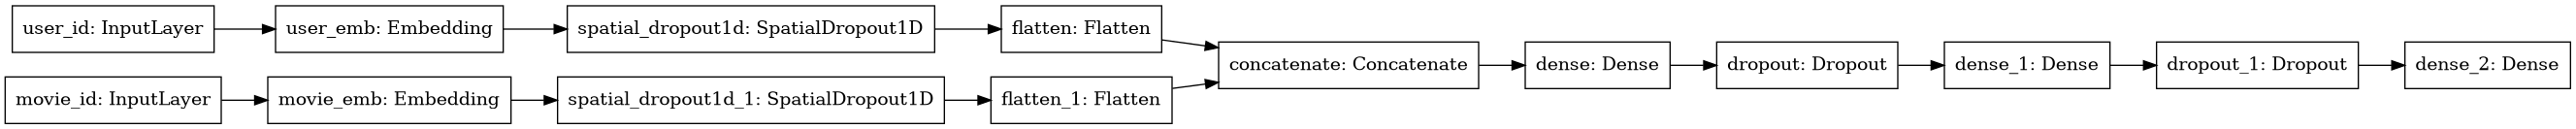

In [6]:
plot_model(movies_cf_r_d, '/tmp/model.png', rankdir='LR')

In [7]:
movies_cf_r_d.compile('adam', 'mse')
movies_cf_r_d_hist = movies_cf_r_d.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 42s 14ms/step - loss: 0.7524 - val_loss: 0.4526
Epoch 2/8
3011/3011 [==============================] - 45s 15ms/step - loss: 0.4789 - val_loss: 0.4421
Epoch 3/8
3011/3011 [==============================] - 44s 15ms/step - loss: 0.4493 - val_loss: 0.4384
Epoch 4/8
3011/3011 [==============================] - 46s 15ms/step - loss: 0.4272 - val_loss: 0.4348


In [8]:
movies_cf_r_d.save('data/movies_cf_r_d.h5')
save(movies_cf_r_d_hist.history, 'data/movies_cf_r_d_history.pickle')

## Evalueren

In [9]:
movies_cf_r_d = load_model('data/movies_cf_r_d.h5')
movies_cf_r_d_history = load('data/movies_cf_r_d_history.pickle')

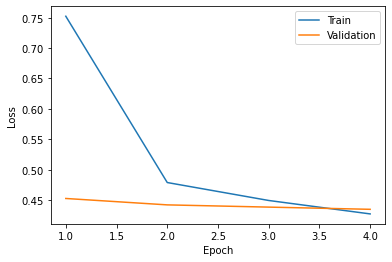

In [10]:
plot_loss(movies_cf_r_d_history);

In [11]:
y_movies_cf_r_d_test = movies_cf_r_d.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_d_train = movies_cf_r_d.predict([X_train['user_id'], X_train['movie_id']])

In [12]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_d_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_d_train)

Test:
MSE = 0.4531018225905073
MAE = 0.5150060997103595
Train:
MSE = 0.42221901525166805
MAE = 0.4953185273379742


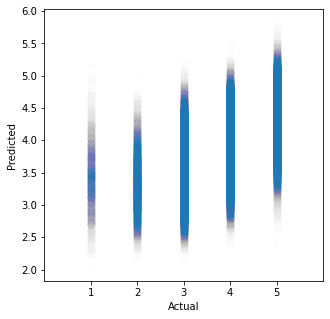

In [13]:
plot_preds(y_test, y_movies_cf_r_d_test);

# Classificatie

In [14]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    SpatialDropout1D(0.1),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(64, 'relu'),
    Dropout(0.1),
    Dense(n_classes, 'softmax')
)
movies_cf_c_d = Model([user_input, movie_input], user_movie, name='movies_cf_c_d')

In [15]:
movies_cf_c_d.summary()

Model: "movies_cf_c_d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
______________________________________________________________________________________

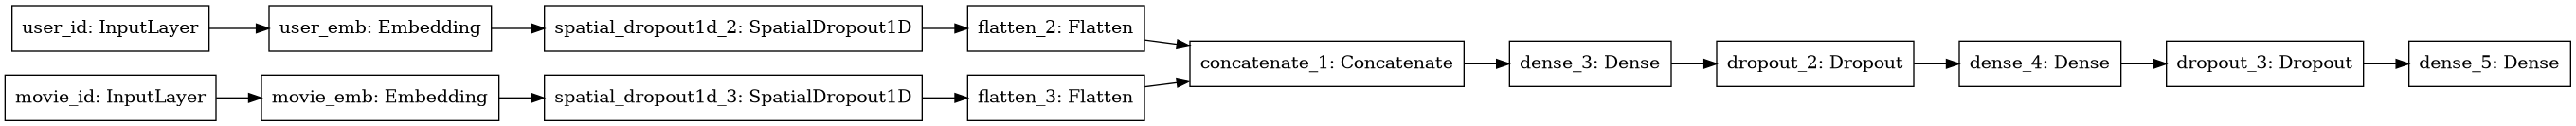

In [16]:
plot_model(movies_cf_c_d, '/tmp/model.png', rankdir='LR')

In [17]:
movies_cf_c_d.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_d_hist = movies_cf_c_d.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 45s 15ms/step - loss: 0.9830 - accuracy: 0.5710 - val_loss: 0.9157 - val_accuracy: 0.5992
Epoch 2/8
3011/3011 [==============================] - 45s 15ms/step - loss: 0.8829 - accuracy: 0.6180 - val_loss: 0.9045 - val_accuracy: 0.6028
Epoch 3/8
3011/3011 [==============================] - 45s 15ms/step - loss: 0.8468 - accuracy: 0.6340 - val_loss: 0.9083 - val_accuracy: 0.6016
Epoch 4/8
3011/3011 [==============================] - 43s 14ms/step - loss: 0.8224 - accuracy: 0.6440 - val_loss: 0.9137 - val_accuracy: 0.6000


In [18]:
movies_cf_c_d.save('data/movies_cf_c_d.h5')
save(movies_cf_c_d_hist.history, 'data/movies_cf_c_d_history.pickle')

## Evalueren

In [19]:
movies_cf_c_d = load_model('data/movies_cf_c_d.h5')
movies_cf_c_d_history = load('data/movies_cf_c_d_history.pickle')

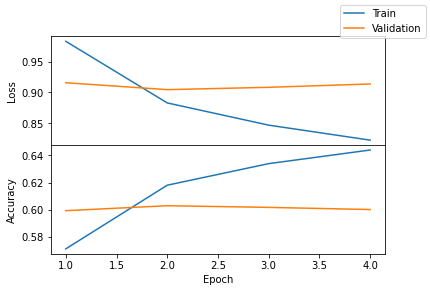

In [20]:
plot_acc(movies_cf_c_d_history);

In [21]:
Y_movies_cf_c_d_test = movies_cf_c_d.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_d_test = Y_movies_cf_c_d_test.argmax(axis=1)
Y_movies_cf_c_d_train = movies_cf_c_d.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_d_train = Y_movies_cf_c_d_train.argmax(axis=1)

In [22]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_d_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_d_train)

Test:


/home/nicolas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1646
           1       0.00      0.00      0.00      4616
           2       0.57      0.49      0.52     42436
           3       0.60      0.75      0.67     77496
           4       0.63      0.50      0.55     34373

    accuracy                           0.60    160567
   macro avg       0.36      0.35      0.35    160567
weighted avg       0.58      0.60      0.58    160567

Train:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4940
           1       0.00      0.00      0.00     13846
           2       0.60      0.52      0.56    127306
           3       0.63      0.78      0.70    232487
           4       0.66      0.53      0.59    103119

    accuracy                           0.63    481698
   macro avg       0.38      0.37      0.37    481698
weighted avg       0.60      0.63      0.61    481698



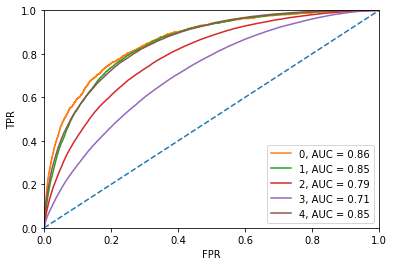

In [23]:
plot_rocc(y_test - 1, Y_movies_cf_c_d_test);

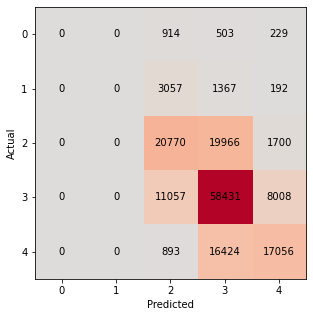

In [24]:
plot_confmat(y_test - 1, y_movies_cf_c_d_test);

In [25]:
print_rg_report(y_test - 1, y_movies_cf_c_d_test)

MSE = 0.5476031812265285
MAE = 0.4438085036153132
